In [38]:
# Imports
import sys
sys.path.append('../../../utils')

from default_imports import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [39]:
# Load data
X_train_raw = pd.read_csv('../data/processed/X_train.csv').drop(columns="PassengerId")
y_train_raw = pd.read_csv('../data/processed/y_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

# MLP Classification
04_MLP_classification.ipynb

This notebook aims to create a simple multilayer perceptron.

Achieved public score: *Not Submitted*

## Dataloaders

In [40]:
class CustomDataset(Dataset):
    def __init__(self, X: pd.DataFrame, y: np.array, transform=None):
        if len(X) != len(y):
            raise ValueError("Length of X and y must be equal.")
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        features = self.X.iloc[index].values
        label = self.y[index]

        features = torch.tensor(features, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            features = self.transform(features)

        return features, label

In [303]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_raw, y_train_raw.values.ravel(), test_size=0.2)

train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CustomDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

complete_dataset = CustomDataset(X_train_raw, y_train_raw.values.ravel())
complete_dataloader = DataLoader(complete_dataset, batch_size=64, shuffle=True)

## Neural Network

### Definition

In [308]:
class SimpleNNClassifier(nn.Module):
    def __init__(self, in_features):
        super(SimpleNNClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=16)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.dropout(x)
        return self.fc2(x)

### Training

In [309]:
def train_nn(model, loss_fn, optimizer, num_epochs, dataloader):
    losses = []
    for epoch in range(num_epochs):
        model.train()

        epoch_losses = []
        for inputs, labels in dataloader:
            optimizer.zero_grad()

            outputs = model(inputs).squeeze()

            loss = loss_fn(outputs, labels.double())

            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(avg_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}", end='\r')

    plt.plot(range(1, num_epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss')
    plt.title('Training Loss per Epoch')
    plt.show()

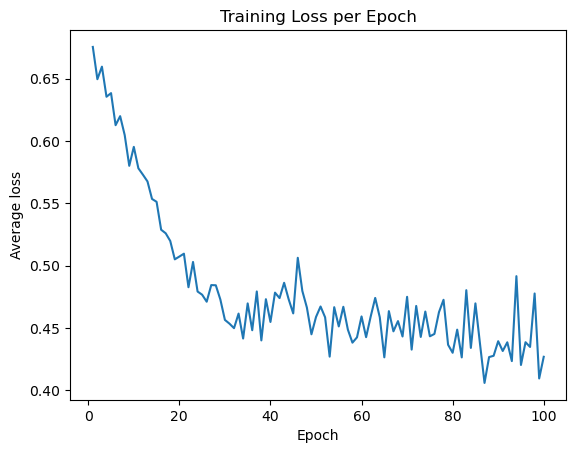

In [315]:
model = SimpleNNClassifier(in_features=X_train.shape[1])

loss_function = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_nn(model, loss_function, optimizer, num_epochs, train_dataloader)

### Evaluation

In [311]:
from torchmetrics.classification import BinaryAccuracy, BinaryRecall, BinaryPrecision

accuracy_fn = BinaryAccuracy()
recall_fn = BinaryRecall()
precision_fn = BinaryPrecision()

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_dataloader:
        outputs = model(inputs).sigmoid().squeeze()
        accuracy_fn(outputs, labels)
        recall_fn(outputs, labels)
        precision_fn(outputs, labels)

accuracy = accuracy_fn.compute().item()
precision = precision_fn.compute().item()
recall = recall_fn.compute().item()

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.8483145833015442
Precision: 0.8727272748947144
Recall: 0.7058823704719543


### Full training

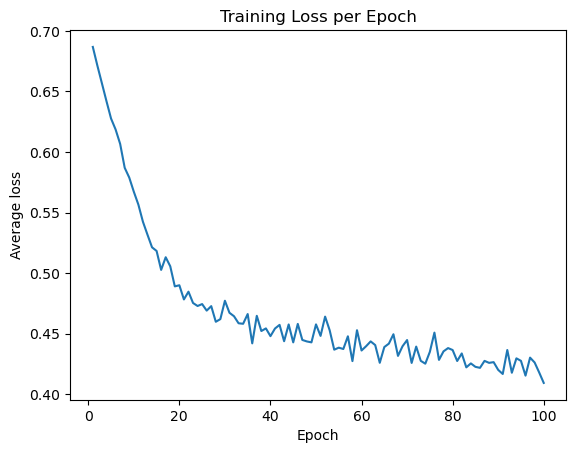

In [312]:
model = SimpleNNClassifier(in_features=X_train.shape[1])

loss_function = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_nn(model, loss_function, optimizer, num_epochs, complete_dataloader)

### Prediction

In [313]:
X = X_test.drop(columns='PassengerId').values
X_tensor = torch.tensor(X, dtype=torch.float32)

with torch.no_grad():
    outputs = model(X_tensor)
    probs = torch.sigmoid(outputs).squeeze()
    preds = (probs > 0.5).int()

preds.numpy()

result = pd.DataFrame({
    'PassengerId': X_test["PassengerId"].astype(int),
    'Survived': preds
})

result.to_csv('../output/MLP_classification.csv', index=False)

result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
